### Notebook used to verify the CWFS algorithm/package developed by Bo Xin. This drives the linear stage to move the telescope simulator focus, takes the appropriate images, then uses the stack to do a basic ISR and image reconstruction before performing the CWFS.

#### This requires that the parameter file for the CWFS algorithm be placed in the cwfs directory structure. It also requires functions I've written that are from my personal repo (https://github.com/patrickingraham/lsst_python_utils.git)

In [1]:
import numpy as np
from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]

import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.afw.display as afwDisplay
#afwDisplay.setDefaultBackend('firefly')
afwDisplay.setDefaultBackend('matplotlib')
import time
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.geom

import os
import lsst.log
lsst.log.usePythonLogging()

import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')


In [22]:
#Import CWFS package
from lsst import cwfs

In [3]:
# Setup the butler
accs_images = True
if accs_images:
    repo = os.path.join("/home/saluser/ingest/accs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    butler = dafPersist.Butler(repo)
else:
    repo = os.path.join("/home/saluser/ingest/dmcs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    butler = dafPersist.Butler(repo)
#raw = butler.get("raw", visit=2019053100020)
#image = raw.getImage().array

2019-09-05 18:49:33,163 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-09-05 18:49:33,165 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


In [4]:
d = salobj.Domain()
ATArchiver = salobj.Remote(d, 'ATArchiver')
await ATArchiver.start_task
ATCamera = salobj.Remote(d, 'ATCamera')
await ATCamera.start_task
#ATMonochromator = salobj.Remote(SALPY_ATMonochromator)
LinearStage1 = salobj.Remote(d, 'LinearStage',1)
await LinearStage1.start_task

2019-09-04 21:19:11,024 ATArchiver   WARNING  Could not read historical data in 60.10 sec
2019-09-04 21:19:12,905 ATCamera     INFO     Read historical data in 0.06 sec
2019-09-04 21:19:13,605 LinearStage  INFO     Read historical data in 0.05 sec


### Leave this cell for state transitions 

In [11]:
#  bring into enable state if required
if True:
    try:
        await LinearStage1.cmd_enable.start(timeout=5)
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")
else:
    print('Ignoring')
#asyncio.get_event_loop().run_until_complete(ATCamera.cmd_start.start())

Failed withs ack=-302,ack.error=1, ackcmd.result=Failed: enable not allowed in state <State.ENABLED: 2>


## Setup the Linear Stage (focuser)

In [12]:
pos=None
pos=await LinearStage1.tel_position.next(flush=True, timeout=5)
print('Current stage position is {:0.4f} [mm]'.format(pos.position))

Current stage position is 31.5000 [mm]


In [13]:
# Home the stage (only necessary if power was off)
if True:
    try:
        await LinearStage1.cmd_getHome.start(timeout=20)
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")
else:
    print('Ignoring')

In [ ]:
# Move the stage to desired position
lin_stage_pos=0.0 #33
LinearStage1.cmd_moveAbsolute.set(distance=lin_stage_pos)
try:
    asyncio.get_event_loop().run_until_complete(LinearStage1.cmd_moveAbsolute.start())
except salobj.AckError as ack_err:
    print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")

In [14]:
# Create details for intra/extra focal image focus offsets
wavelength=455
focus_center=33.85 # for 632nm no filter, no grating
focus_center = 27.5 # for 455nm no filter, no grating

dx=27.0
focus_demands = np.array((focus_center-dx, focus_center, focus_center+dx))
#focus_vals = np.arange(68.4, 71.3, 0.3) - coarse
print(focus_demands)

[ 0.5 27.5 54.5]


In [100]:
# Get images 
image_list=[]
focus_vals=np.empty(len(focus_demands))
for i,lin_stage_pos in enumerate(focus_demands):
    #print('Beginning sweep at focus {} [mm]'.format(lin_stage_pos))
    
    # Move focus stage
    LinearStage1.cmd_moveAbsolute.set(distance=lin_stage_pos)
    try:
        await LinearStage1.cmd_moveAbsolute.start()
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")
    
    # shouldn't have to do this but sometimes it pulls the wrong value, need to look into this
    # will test when new version is released (imminent)
    await asyncio.sleep(3.0)
    focus_vals[i]=(await LinearStage1.tel_position.next(flush=True, timeout=5)).position
    print('Linear stage demand {}, actual {}:'.format(lin_stage_pos, focus_vals[i]))
    
    # Take image with appropriate exposure times
    group_id='Focus,wavelength = {},{}'.format(str(lin_stage_pos), str(wavelength))
    #exptime=0.2 for 632 laser with ND4
    #exptime=5 for 455nm LED ND3, but focused images saturates
    if i != 1:
        expTime = 5 # out of focus expTime
    else:
        expTime = 0.5
    
    ATCamera.cmd_takeImages.set(expTime=expTime, shutter=1, numImages=1, imageSequenceName=group_id)
    ATCamera.evt_endReadout.flush()
    try:
        await ATCamera.cmd_takeImages.start()
    except salobj.AckError as ack_err:
        print(f"Failed withs ack={ack_err.ackcmd.ack},ack.error={ack_err.ackcmd.error}, ackcmd.result={ack_err.ackcmd.result}")

    endReadout = await ATCamera.evt_endReadout.next(flush=False, timeout=30)
    print('Wrote file {}'.format(endReadout.imageName) )
    
    image_list.append(endReadout.imageName)

2019-09-04 22:19:24,029 ATCamera     WARNING  RemoteTelemetry(ATCamera, 0, wrebPower) falling behind; read 80 messages
2019-09-04 22:19:24,042 ATCamera     WARNING  RemoteTelemetry(ATCamera, 0, wreb) falling behind; read 76 messages


Linear stage demand 0.5, actual 0.5:
Wrote file AT_O_20190904_000066
Linear stage demand 27.5, actual 27.5:
Wrote file AT_O_20190904_000067
Linear stage demand 54.5, actual 54.5:
Wrote file AT_O_20190904_000068


In [101]:
for index, img in enumerate(image_list):
    print('{}, {:0.2f}'.format(img, focus_vals[index]))

AT_O_20190904_000066, 0.50
AT_O_20190904_000067, 27.50
AT_O_20190904_000068, 54.50


In [10]:
import importlib
import utils.processExposure 
importlib.reload(utils.processExposure)
from utils.processExposure import processExposure


import utils.grabATImage 
importlib.reload(utils.grabATImage)
from utils.grabATImage import grabATImage

In [104]:
# parse out visitID from filename - this is highly annoying
tmp=endReadout.imageName.split('_')
prefix=tmp[2] # dayobs without the dashes

# Don't remember why I used int here... whitespace? 
# surely fixable but bigger fish.
suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
visitID = int((prefix+suffix))
dataId1 = {'visit': visitID}
print(visitID)

# Grab image from butler, but need to wait to ingestion so use this polling function
exposure = await grabATImage(visitID, repo, timeout = 40, poll_freq_hz=2)

# do ISR correction
isr_corr_exposure = processExposure(exposure, repo=repo)

2019-09-04 22:20:38,697 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-09-04 22:20:38,698 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


2019090400068


2019-09-04 22:20:39,865 LsstCamMapper WARNING  amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-09-04 22:20:40,113 lsst.obs.lsst.translators.auxTel WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-09-04 22:20:40,114 lsst.obs.lsst.translators.auxTel WARNING  Unable to determine observation type. Guessing 'unknown'
2019-09-04 22:20:40,117 LsstCamMapper WARNING  argDict[boresightAirmass] is None; stripping
2019-09-04 22:20:40,118 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019090400068}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-09-04 22:20:40,182 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-09-04 22:20:40,183 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Exposure retrieved after waiting 1.52 [s]


2019-09-04 22:20:41,350 isr          INFO     Converting exposure to floating point values.
2019-09-04 22:20:41,619 isr          INFO     Assembling CCD from amplifiers.
2019-09-04 22:20:41,743 isr          WARNING  No WCS found in input exposure.
2019-09-04 22:20:41,744 isr          INFO     Applying bias correction.
2019-09-04 22:20:42,248 isr          INFO     Masking NAN value pixels.
2019-09-04 22:20:42,274 isr          INFO     Widening saturation trails.
2019-09-04 22:20:42,298 isr          INFO     Interpolating masked pixels.
2019-09-04 22:20:43,307 isr          WARNING  No rough magnitude zero point set for filter NONE.
2019-09-04 22:20:43,308 isr          INFO     Setting rough magnitude zero point: 29.747425
2019-09-04 22:20:43,327 LinearStage  WARNING  RemoteEvent(LinearStage, 1, heartbeat) falling behind; read 35 messages


Time to perform image ISR was 1.959477 [s]


In [8]:
# Only here for me to debug, should be up top with other declarations
import importlib
import utils.findNarrowbandRonchiPeaks
importlib.reload(utils.findNarrowbandRonchiPeaks)
from utils.findNarrowbandRonchiPeaks import findNarrowbandRonchiPeaks

import utils.fitExposure
importlib.reload(utils.fitExposure)
from utils.fitExposure import fit2DGaussian

import utils.calc_CofM
importlib.reload(utils.calc_CofM)
from utils.calc_CofM import calc_CofM

import utils.calc_encircled_energy
importlib.reload(utils.calc_encircled_energy)
from utils.calc_encircled_energy import calc_encircled_energy

In [9]:
# Source detection libraries
from lsst.meas.algorithms.detection import SourceDetectionTask
import lsst.afw.table as afwTable

# create the output table for source detection
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 5  # detection threshold after smoothing
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)

In [107]:
# I don't like looping but apparently there is no way to reduce multiple files from a notebook
# Declare approximation of where the zero-order star is
zeroth_order_estimate = lsst.geom.Point2D(1700,1960)
zeroth_order_estimate = lsst.geom.Point2D(2075,2025) # low res grating
zeroth_order_estimate = lsst.geom.Point2D(2260,2050) #empty (632)
zeroth_order_estimate = lsst.geom.Point2D(2090,2220) #empty (455)
zeroth_order_star_BBox= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(200,200)) 

fit_data=[]
visitIDs=[]

for index, img_name in enumerate(image_list):
    # parse out visitID from filename - this is highly annoying
    print('Processing file {} of {}, filename={}'.format(index,len(image_list), img_name))
    tmp=img_name.split('_')
    prefix=tmp[2] # dayobs without the dashes
    # Don't remember why I used int here... whitespace? 
    # surely fixable but bigger fish.
    suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
    visitID = int((prefix+suffix))
    visitIDs.append(visitID)
    #dataId1 = {'visit': visitID}
    #multi_file_dataset[i]['visitID']=visitID
    
    # Doing this if the source finding is failing
    # 
    
    continue
    
    #exposure = butler.get('raw', **dataId1)
    exposure = await grabATImage(visitID, repo, timeout = 40, poll_freq_hz=2)
    # do ISR correction
    isr_corr_exposure = processExposure(exposure, repo=repo, defects=None) #bias=None
    
    # Find all sources in the image
    tab = afwTable.SourceTable.make(schema)
    # Find the correct sources using just a strip
    search_center_pt = lsst.geom.Point2D(zeroth_order_estimate.getX(),2000)
    search_strip = lsst.geom.Box2I.makeCenteredBox(search_center_pt, lsst.geom.Extent2I(500,3999)) 
    result = sourceDetectionTask.run(tab, isr_corr_exposure[search_strip], sigma=15.0)
    
    # wavelength solution is bad for the fiberSpectrograph, but close enough for this to work
    # can use the monochromator wavelength which is better, but that's not the correct way in the long run

    if True: # display the image in firefly
        plt.close('all')
        disp = afwDisplay.Display(2, reopenPlot=True)
        disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
        disp.setImageColormap('gray')
        disp.scale('linear', 'minmax')
        peak0_subim = isr_corr_exposure.subset(zeroth_order_star_BBox)
        disp.mtv(peak0_subim, title='visit = {}'.format(visitID))        
        #disp.scale('linear', 'zscale')
        #disp.mtv(isr_corr_exposure, title='visit = {}'.format(visitID))
        #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)
        break
        
    
    dispersion = (1/0.6358) # pixels/nm
    spectral_position_angle=0.0107 # radians clockwise from top

    # Find 0th and +/- 1 order peaks 
    sources = result.sources
    dispersion=None
    center_source = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)
#    center_source, peak1, peak2 = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)
    
    # Fit peaks
    # zeroth order
    # variables names are weird here because I can't think of a clever way to have -1 and +1 as variable names
    
    bbox0 = lsst.geom.Box2I.makeCenteredBox(center_source.getFootprint().getCentroid(), lsst.geom.Extent2I(190,190)) 
    peak0_subim = isr_corr_exposure.subset(bbox0)
    p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)
    p0_x_CofM, p0_y_CofM = calc_CofM(peak0_subim) # 2167,3372

# Calculate EE and CofM
    p0_EE_rad50_pix, p0_EE_rad67_pix, p0_EE_rad80_pix = calc_encircled_energy(peak0_subim, plot=False) 
    fit_data.append(p0_EE_rad80_pix)

#     # offset to test
#     bbox1 = lsst.geom.Box2I.makeCenteredBox(peak1.getFootprint().getCentroid(), lsst.geom.Extent2I(50,50)) 
#     peak1_subim = isr_corr_exposure.subset(bbox1)
#     p1, x1 , y1 = fit2DGaussian(peak1_subim, plot=True)
#     p1_x_CofM, p1_y_CofM = calc_CofM(peak1_subim) # 2167,3372
#     fit_data.append(p1_EE_rad67_pix)


Processing file 0 of 3, filename=AT_O_20190904_000066
Processing file 1 of 3, filename=AT_O_20190904_000067
Processing file 2 of 3, filename=AT_O_20190904_000068


In [4]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [6]:
# Can declare visit IDs if you want to use old data
# visitIDs=[2019090400066, 2019090400067, 2019090400068]

In [11]:
# get images 
intra_exposure = await grabATImage(visitIDs[0], repo, timeout = 40, poll_freq_hz=2)
focus_exposure = await grabATImage(visitIDs[1], repo, timeout = 40, poll_freq_hz=2)
extra_exposure = await grabATImage(visitIDs[2], repo, timeout = 40, poll_freq_hz=2)
isr_corr_exposure_intra = processExposure(intra_exposure, repo=repo, defects=None) #bias=None
isr_corr_exposure_focus = processExposure(focus_exposure, repo=repo, defects=None) #bias=None
isr_corr_exposure_extra = processExposure(extra_exposure, repo=repo, defects=None) #bias=None

2019-09-05 18:50:31,339 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-09-05 18:50:31,341 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3
2019-09-05 18:50:31,867 LsstCamMapper WARNING  amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-09-05 18:50:31,994 lsst.obs.lsst.translators.auxTel WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-09-05 18:50:31,994 lsst.obs.lsst.translators.auxTel WARNING  Unable to determine observation type. Guessing 'unknown'
2019-09-05 18:50:32,710 LsstCamMapper WARNING  argDict[boresightAirmass] is None; stripping
2019-09-05 18:50:32,711 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019090400066}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-09-05 18:50:32,799 CameraMapper INFO     Loading expo

Exposure retrieved after waiting 1.49 [s]


2019-09-05 18:50:33,209 LsstCamMapper WARNING  amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-09-05 18:50:33,368 lsst.obs.lsst.translators.auxTel WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-09-05 18:50:33,369 lsst.obs.lsst.translators.auxTel WARNING  Unable to determine observation type. Guessing 'unknown'
2019-09-05 18:50:33,372 LsstCamMapper WARNING  argDict[boresightAirmass] is None; stripping
2019-09-05 18:50:33,373 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019090400067}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-09-05 18:50:33,438 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-09-05 18:50:33,440 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Exposure retrieved after waiting 0.66 [s]


2019-09-05 18:50:33,868 LsstCamMapper WARNING  amp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
2019-09-05 18:50:34,064 lsst.obs.lsst.translators.auxTel WARNING  Explicit dark time not found, setting dark time to the exposure time.
2019-09-05 18:50:34,065 lsst.obs.lsst.translators.auxTel WARNING  Unable to determine observation type. Guessing 'unknown'
2019-09-05 18:50:34,068 LsstCamMapper WARNING  argDict[boresightAirmass] is None; stripping
2019-09-05 18:50:34,069 LsstCamMapper WARNING  Unable to set WCS for DataId(initialdata={'visit': 2019090400068}, tag=set()) from header as RA/Dec/Angle are unavailable
2019-09-05 18:50:34,141 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-09-05 18:50:34,143 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Exposure retrieved after waiting 0.70 [s]


2019-09-05 18:50:35,366 isr          INFO     Converting exposure to floating point values.
2019-09-05 18:50:35,654 isr          INFO     Assembling CCD from amplifiers.
2019-09-05 18:50:35,776 isr          WARNING  No WCS found in input exposure.
2019-09-05 18:50:35,777 isr          INFO     Applying bias correction.
2019-09-05 18:50:36,235 isr          INFO     Masking NAN value pixels.
2019-09-05 18:50:36,261 isr          INFO     Widening saturation trails.
2019-09-05 18:50:36,299 isr          INFO     Interpolating masked pixels.
2019-09-05 18:50:37,318 isr          WARNING  No rough magnitude zero point set for filter NONE.
2019-09-05 18:50:37,318 isr          INFO     Setting rough magnitude zero point: 29.747425
2019-09-05 18:50:37,385 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-09-05 18:50:37,386 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Time to perform image ISR was 1.958283 [s]


2019-09-05 18:50:38,543 isr          INFO     Converting exposure to floating point values.
2019-09-05 18:50:38,831 isr          INFO     Assembling CCD from amplifiers.
2019-09-05 18:50:38,954 isr          WARNING  No WCS found in input exposure.
2019-09-05 18:50:38,955 isr          INFO     Applying bias correction.
2019-09-05 18:50:39,403 isr          INFO     Masking NAN value pixels.
2019-09-05 18:50:39,424 isr          INFO     Widening saturation trails.
2019-09-05 18:50:39,444 isr          INFO     Interpolating masked pixels.
2019-09-05 18:50:40,326 isr          WARNING  No rough magnitude zero point set for filter NONE.
2019-09-05 18:50:40,327 isr          INFO     Setting rough magnitude zero point: 27.247425
2019-09-05 18:50:40,394 CameraMapper INFO     Loading exposure registry from /home/saluser/ingest/accs/registry.sqlite3
2019-09-05 18:50:40,395 CameraMapper INFO     Loading calib registry from /home/saluser/ingest/accs/CALIB/calibRegistry.sqlite3


Time to perform image ISR was 1.790000 [s]


2019-09-05 18:50:41,484 isr          INFO     Converting exposure to floating point values.
2019-09-05 18:50:41,773 isr          INFO     Assembling CCD from amplifiers.
2019-09-05 18:50:41,897 isr          WARNING  No WCS found in input exposure.
2019-09-05 18:50:41,898 isr          INFO     Applying bias correction.
2019-09-05 18:50:42,314 isr          INFO     Masking NAN value pixels.
2019-09-05 18:50:42,332 isr          INFO     Widening saturation trails.
2019-09-05 18:50:42,355 isr          INFO     Interpolating masked pixels.
2019-09-05 18:50:43,226 isr          WARNING  No rough magnitude zero point set for filter NONE.
2019-09-05 18:50:43,227 isr          INFO     Setting rough magnitude zero point: 29.747425


Time to perform image ISR was 1.748909 [s]


In [12]:
focus_center = lsst.geom.Point2D(2110,2250)
intra_center = lsst.geom.Point2D(2090,2280)
extra_center=lsst.geom.Point2D(2130,2230) ; 
bbox_focus= lsst.geom.Box2I.makeCenteredBox(focus_center, lsst.geom.Extent2I(160,160))
bbox_intra= lsst.geom.Box2I.makeCenteredBox(intra_center, lsst.geom.Extent2I(160,160))
bbox_extra= lsst.geom.Box2I.makeCenteredBox(extra_center, lsst.geom.Extent2I(160,160))


In [13]:
fieldXY = [0.0,0.0]
I_focus = Image(isr_corr_exposure_focus.subset(bbox_focus).image.array, fieldXY, Image.EXTRA)
I1 = Image(isr_corr_exposure_intra.subset(bbox_intra).image.array, fieldXY, Image.INTRA)
I2 = Image(isr_corr_exposure_extra.subset(bbox_extra).image.array, fieldXY, Image.EXTRA)

In [21]:
hdu = fits.PrimaryHDU(isr_corr_exposure_intra.subset(bbox_intra).image.array)
hdul = fits.HDUList([hdu])
hdul.writeto('/home/saluser/develop/I1_intra.fits', overwrite=True)
hdu2 = fits.PrimaryHDU(isr_corr_exposure_extra.subset(bbox_extra).image.array)
hdul2 = fits.HDUList([hdu2])
hdul2.writeto('/home/saluser/develop/I2_extra.fits', overwrite=True)

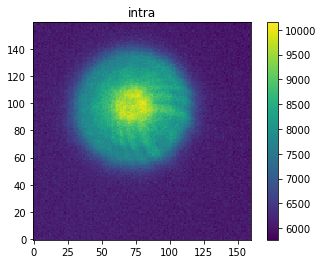

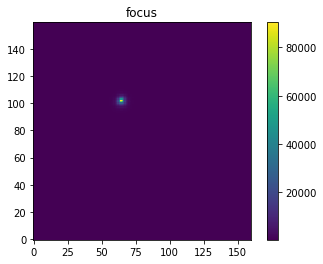

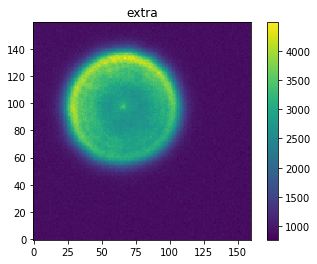

In [114]:
plots.plotImage(I1.image,'intra')
plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')

In [115]:
# declare instrument - example
#inst=Instrument('lsst',I1.sizeinPix) # example

In [127]:
inst=Instrument('auxtel_simulator',I1.sizeinPix) # example

In [128]:
# declare algorithm - exponential
algo=Algorithm('exp',inst,1) # example

In [129]:
algo.runIt(inst,I1,I2,'paraxial')

In [119]:
# run it - example
#algo.runIt(inst,I1,I2,'offAxis')

In [120]:
#print zernikes
print(algo.zer4UpNm)

[ 9.55720271e+01  7.20747608e+00  2.42445496e+01  7.36696395e+00
  2.21726037e-01  1.43049749e+00  7.33874357e-01 -5.74630479e+00
  2.06789036e+00  2.11336030e-02 -1.61104960e+00 -3.40746535e-01
  7.02350455e-01 -2.06754582e+00 -8.87010912e-02 -1.61818839e-01
 -8.18188578e-01 -3.70131810e-01  5.57155304e+00]


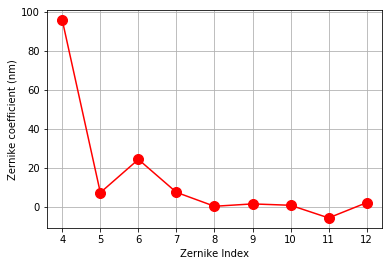

In [121]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')


In [ ]:
plots.plotImage(algo.Wconverge,'Final wavefront')

In [ ]:
plots.plotImage(algo.Wconverge,'Final wavefront with pupil mask applied', mask=algo.pMask)

In [ ]:
# Basic math to estimate the expected result
D=25e-3; wave=632e-9
f_coll=125e-3; 

f_tel=400e-3 # 400mm nominal
pinhole_diam=10e-6

print('Diffraction Limit (f=125mm, D=25mm, wave=632nm) is: {0:3f} [um]'.format(1e6*wave/D*f_coll))
mag=f_tel/f_coll
print('Magnification is f_tel/f_col {}:'.format(mag))
im_size=1e6*mag*pinhole_diam
print('Expected image diameter for {0:3f} diameter pinhole: {1:3f} [um]'.format(pinhole_diam, im_size))
print('80% EE radius in pixels ~{}'.format(im_size/2/10))